In [ ]:
# VA Note : from this notebook location, data is located in ../data
#           in /data/train, /data/valid, /data/test

In [1]:
import numpy as np

import cv2                

import matplotlib.pyplot as plt                        
%matplotlib inline  

In [3]:
import os

import torch
from torchvision import datasets

# VA added: 
import torchvision.transforms as transforms
import torchvision
#from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import WeightedRandomSampler

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
rootDataDir = 'data' # on local repo
trainDataPath = os.path.join(rootDataDir, 'train/')
validDataPath = os.path.join(rootDataDir, 'valid/')
testDataPath = os.path.join(rootDataDir, 'test/')

imgResize = 256
imgSize = 224    # let's  start small, but using same size as images used for pre trained model used below
# Note : we first downsize a little, rotate (possibly introducing black areas in the corners), then center crop at final size
train_transform = transforms.Compose([
                        #transforms.Resize((imgSize, imgSize)),
                        transforms.Resize(imgResize),
                        #transforms.RandomResizedCrop(size=(imgSize, imgSize)),
                        #transforms.RandomResizedCrop(size=(imgSize, imgSize), scale=(0.08, 0.60), ratio=(0.75, 1.333333), interpolation=2),
                        transforms.RandomHorizontalFlip(), # augmentation : randomly flip...
                        transforms.RandomRotation(10),  #  ...and random rotate
                        transforms.CenterCrop(imgSize), # 
                        #transforms.RandomResizedCrop(size=(imgSize, imgSize)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                        #transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
                        ]) # last for color rectif. (JPG img)
basic_transform = transforms.Compose([
                        transforms.Resize(imgResize),
                        transforms.CenterCrop(imgSize), 
                        #transforms.Resize((imgSize, imgSize)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                        #transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
                        ])
# above should provide a normalized, 3 color-planes, 224 px image
    
train_data = torchvision.datasets.ImageFolder(trainDataPath, transform=train_transform)
valid_data = torchvision.datasets.ImageFolder(validDataPath, transform=basic_transform)
# for final model eval :
test_data = torchvision.datasets.ImageFolder(testDataPath, transform=basic_transform)

# show loaded data infos :
print("total TRAIN images :{}".format(len(train_data)))
print("total VALID images :{}".format(len(valid_data)))
print("total TEST  images :{}".format(len(test_data)))

targetClasses = len(train_data.classes)
print("number of classes in TRAIN data : {}".format(targetClasses))

''' # NOT USED finally :
# takes as input a Train/valid data loaded above (train_data or valid_data)
# and returns the indiv. samples weight array to fix the unbalanced data set
# by using sample drawn using a WeightedRandomSampler
def getDataSampleWeight(dataSet):
    # step 1: get classes occurences (for that dataset)
    classOccurences = np.zeros(len(dataSet.classes))
    for idx in range(len(dataSet)):
        (sample,target) = dataSet.__getitem__(idx)
        #print("s_type:{} t_type:{}".format(type(sample), type(target) ))
        classOccurences[target] +=1 
    classWeights = 1.0 / (classOccurences +1.0) # len(train_data) / trainClassOccur
    # step 2: get indiv. sample weight array, using above computed info
    dataSamplesWeights = np.zeros(len(dataSet))
    for idx in range(len(dataSet)):
        (sample,target) = dataSet.__getitem__(idx)
        dataSamplesWeights[idx] = classWeights[target]
    return classOccurences, dataSamplesWeights   

# VA NOTE : classes distribution is not equal (more image in some train img folders)
# so try using weight assisted training sample pick

trainClassOccurences, trainDataSamplesWeights = getDataSampleWeight(train_data)
print("classes' label occurence (for TRAIN data) :\n{}".format(trainClassOccurences[:]))
#print("First 20 TRAIN indiv. sample's weight :\n{}".format(trainDataSamplesWeights[:20]))

#validClassOccurences, validDataSamplesWeights = getDataSampleWeight(valid_data)
#print("First 20 classes' label occurence (for VALID data) :\n{}".format(validClassOccurences[:20]))
#print("First 20 VALID indiv. sample's weight :\n{}".format(validDataSamplesWeights[:20]))

# NOT USED finally :
# caution :  below must be provided indiv. sample weights, NOT the sample's CLASS weight
# torch.utils.data.WeightedRandomSampler(weights, num_samples, replacement=True)
train_wrSampler = torch.utils.data.WeightedRandomSampler(trainDataSamplesWeights, len(train_data), replacement=False)
#valid_wrSampler = torch.utils.data.WeightedRandomSampler(validDataSamplesWeights, len(valid_data), replacement=False)
'''

# define dataloader parameters
batch_size = 20
num_workers=0

### using both a Data Sampler AND the SHUFFLE option in DataLoader triggers
#      error 'sampler option is mutually exclusive with shuffle', 
#      so use one or the other (The sampler option i prepared is for unbalanced datasets)

# prepare data loaders :
# Note 1 : USING a SAMPLER is NOT COMPATIBLE with SHUFFLE option
# Note 2 : SHUFFLE should be used on TRAINing data only
'''
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, sampler=train_wrSampler, shuffle=False)
#valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
#                                          num_workers=num_workers, sampler=valid_wrSampler, shuffle=False)
'''
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)  # SHUFFLE for training data                                
#'''
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=False)  # not SHUFFLE for validation/test data

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False)

# prepare testing Network below :
data_loader_dic = {'train' : train_loader, 'valid' : valid_loader,'test' : test_loader}

total TRAIN images :2000
total VALID images :150
total TEST  images :600
number of classes in TRAIN data : 3


first train set read, # images 20, # labels 20 
shaped batch images (20, 3, 224, 224), # shaped labels torch.Size([20]) 


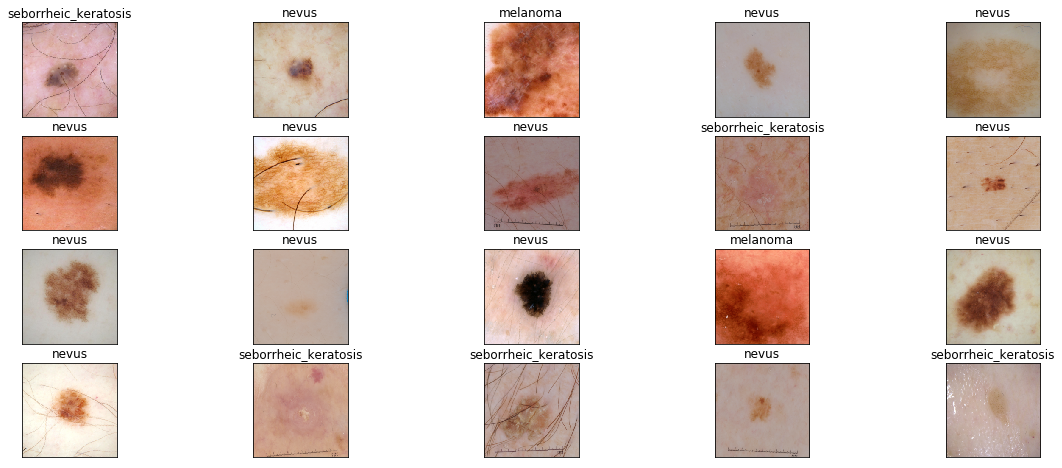

In [12]:
# Visualize some sample data

# helper function to un-normalize and display an image
def imshow(img):
    # unormalize (specific to applied normalization in above transform)
    #case: transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
    #img = img / 2 + 0.5  # unnormalize
    # case: transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])                       
    img[0] = img[0] *0.229 +0.485
    img[1] = img[1] *0.224 +0.456
    img[2] = img[2] *0.225 +0.406
    img_t = np.transpose(img, (1, 2, 0)) # get view from 3x128x128 to 128x128x3 shape
    plt.imshow(img_t)
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labelIndex = dataiter.next()
images = images.numpy() # convert images to numpy for display

print("first train set read, # images {}, # labels {} ".format(len(images), len(labelIndex)))
print("shaped batch images {}, # shaped labels {} ".format(images.shape,labelIndex.shape))

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])    
    ax.set_title( train_data.classes[labelIndex[idx]] )
    
# prepare testing Network below :
loaders_data = {'train' : train_loader, 'valid' : valid_loader,'test' : test_loader}

In [51]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
#VA : Load the pretrained model from pytorch, 
#      and then replace its classifier final stage

#vgg19 = models.vgg19(pretrained=True)
vgg19 = models.vgg19_bn(pretrained=True)

print("initial pretrained model architecture:\n{}".format(vgg19))

# show original INPUTs of the classifier part (first Linear layer inputs)
# and LAST classifier part (i.e. its last Linear layer output, i.e. classes usable for classif)
#print(vgg19.classifier[0].in_features) 
#print(vgg19.classifier[6].out_features) 

# like for a VGG16 model, 
# we then need to Freeze learned parameters for "Features" layers,

for param in vgg19.features.parameters():
    if None != param.requires_grad:
        param.requires_grad = False
        #print("for param: {}".format(param.requires_grad))




# APPROACH ONE :
'''
# TWEAK last linear layer (n_inputs -> 3 skin disease classes)
nl_inputs = vgg19.classifier[6].in_features
last_layer = nn.Linear(nl_inputs, targetClasses)
vgg19.classifier[6] = last_layer
# check to see that your last layer produces the expected number of outputs
print("Classifier final outputs NOW SET TO : {}".format(vgg19.classifier[6].out_features))
'''

# APPROACH 2 : redefine the classifier layers (Linears one)
# NOTE : new layers automatically have requires_grad = True
nf_inputs = vgg19.classifier[0].in_features
skinDiseasesClassifer = nn.Sequential( nn.Linear(nf_inputs, 2048),
                             nn.ReLU(inplace=True),
                             nn.Dropout(p=0.50),
                             nn.Linear(2048, 1024),
                             nn.ReLU(inplace=True),
                             nn.Dropout(p=0.50),
                             nn.Linear(1024, targetClasses))
# assign our freshly defined defined classifier
vgg19.classifier = skinDiseasesClassifer


print("New ready to train assigned classifier:{}".format(vgg19.classifier))


#print(vgg19)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# if GPU is available, move the model to GPU
if use_cuda:
    vgg19 = vgg19.cuda()
    



initial pretrained model architecture:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [52]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # None
optimizer = optim.SGD(vgg19.classifier.parameters(), lr=0.001) #only Final layer parameters are tuned

In [53]:
# VA added : training code :

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
        """returns trained model"""
        # initialize tracker for minimum validation loss
        valid_loss_min = np.Inf 

        for epoch in range(1, n_epochs+1):
            # initialize variables to monitor training and validation loss
            train_loss = 0.0
            valid_loss = 0.0

            ###################
            # train the model #
            ###################
            model.train()
            for batch_idx, (data, target) in enumerate(loaders['train']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## find the loss and update the model parameters accordingly
                ## record the average training loss, using something like
                ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                # VA :
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
                # update training loss
                train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            ######################    
            # validate the model #
            ######################
            model.eval()
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update average validation loss 
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))


            # print training/validation statistics 
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))

            ## TODO: save the model if validation loss has decreased
            # VA :
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(model.state_dict(), save_path)
                valid_loss_min = valid_loss

        # return trained model
        return model

n_epochs = 55 #15        
# end of VA add

# train the model
vgg19_scratch = train(n_epochs, loaders_data, vgg19, optimizer, criterion, use_cuda, 'model_cancer_vgg19_transfer_learning.pt')


Epoch: 1 	Training Loss: 1.056719 	Validation Loss: 1.058435
Validation loss decreased (inf --> 1.058435).  Saving model ...
Epoch: 2 	Training Loss: 0.937448 	Validation Loss: 1.054642
Validation loss decreased (1.058435 --> 1.054642).  Saving model ...
Epoch: 3 	Training Loss: 0.870553 	Validation Loss: 1.085010
Epoch: 4 	Training Loss: 0.844031 	Validation Loss: 1.104363
Epoch: 5 	Training Loss: 0.833183 	Validation Loss: 1.115760
Epoch: 6 	Training Loss: 0.827825 	Validation Loss: 1.107635
Epoch: 7 	Training Loss: 0.815750 	Validation Loss: 1.103509
Epoch: 8 	Training Loss: 0.809950 	Validation Loss: 1.092072
Epoch: 9 	Training Loss: 0.804411 	Validation Loss: 1.079177
Epoch: 10 	Training Loss: 0.800719 	Validation Loss: 1.071167
Epoch: 11 	Training Loss: 0.791517 	Validation Loss: 1.068492
Epoch: 12 	Training Loss: 0.784847 	Validation Loss: 1.059612
Epoch: 13 	Training Loss: 0.782881 	Validation Loss: 1.050392
Validation loss decreased (1.054642 --> 1.050392).  Saving model ...
E

In [54]:

# load the model that got the best validation accuracy (uncomment the line below)
vgg19.load_state_dict(torch.load('model_cancer_vgg19_transfer_learning.pt'))

print("vgg19 : {}".format(vgg19))

vgg19 : VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(

In [55]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_data, vgg19, criterion, use_cuda)

Test Loss: 0.703353


Test Accuracy: 68% (410/600)


In [56]:
# test a specific image, display the 3 classes belong proba, the return most probale class

# the following import is required to be robust to truncated images
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True

def predict_class_type(img_path):
    # load the image and return the predicted class
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = Image.open(img_path).convert('RGB')
    # let's resize img to fit model used size
    imgResize = 256
    imgSize = 224 # same size then the img size used for training CNN
    in_transform = transforms.Compose([
                        transforms.Resize(imgResize),
                        transforms.CenterCrop(imgSize), 
                        #transforms.Resize((imgSize, imgSize)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                        #transforms.Resize((size,size)),
                        #transforms.ToTensor(),
                        #transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
                        ]) # last normalisation
    # we should have a normalized, 3 color-planes, 128 px image
    
    image = in_transform(image).unsqueeze(0)  # need unsqueeze as only one image loaded (not a batch), to add 1 dim
    
    # move it to gpu if needed
    if use_cuda:
        image = image.cuda()
    # get the prediction from the trained model
    vgg19.eval()
    class_pred = vgg19(image)
    
    # class pred. should be an array with 3 (skin disease type) classes values here, 
    
    # back to cpu ?
    if use_cuda:
        class_pred = class_pred.cpu()
    
    #print("Classes pred shape:{} and data:{}".format(class_pred.shape, class_pred.data))
    
    # convert output probabilities to predicted class
    #    pred = output.data.max(1, keepdim=True)[1]
    # we will return the highest one
    
    val, idx = torch.max(class_pred, 1)
    # VA: get output back as proba
    sm =torch.nn.Softmax(dim=1) #torch.nn.Softmax(dim=None)
    classesProba = sm(class_pred) 
    #print("class.val:{}, -> class.idx = {} , all classes proba :{}".format(class_pred, idx, classesProba)) #torch.nn.Softmax(dim=None)
        
    
    pred_disease_class = train_data.classes[idx]
    #print("class. predic. values:{} , max.Prob.Class.Idx:{}, named:{}".format(val, idx, pred_disease_class))
    
    return  pred_disease_class, idx, classesProba # return pred_class, its index, and ALL classes proba

In [57]:
def show_image(img_path):
    # load color (BGR) image
    img = cv2.imread(img_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # display the image
    plt.imshow(cv_rgb)
    plt.show()

def handle_query_image(img_path):
    show_image(img_path)
    # what this image is closest to in term of skin disease ?
    pred_class, pred_class_idx, classesProba = predict_class_type(img_path)
    print("Closest skin disease classe is : {}\n".format(pred_class))
 
def run_app(img_path):
    print("- Processing : {} -".format(img_path))
    ## submit image query (+ display)
    handle_query_image(img_path)
    print("--------------------------------")

Will test some of the 42 image(s) from folder data\extra/
- Processing : data\extra\melanoma\ISIC_0000002.jpg -


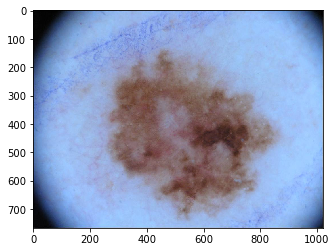

Closest skin disease classe is : melanoma

--------------------------------
- Processing : data\extra\melanoma\ISIC_0000004.jpg -


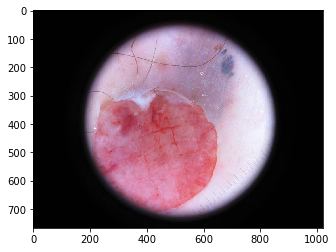

Closest skin disease classe is : melanoma

--------------------------------
- Processing : data\extra\melanoma\ISIC_0000013.jpg -


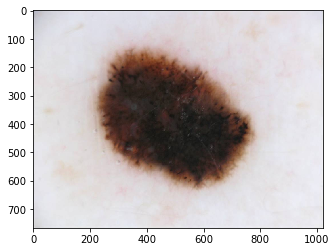

Closest skin disease classe is : nevus

--------------------------------
- Processing : data\extra\melanoma\ISIC_0000022.jpg -


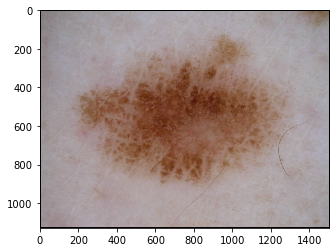

Closest skin disease classe is : nevus

--------------------------------
- Processing : data\extra\melanoma\ISIC_0000026.jpg -


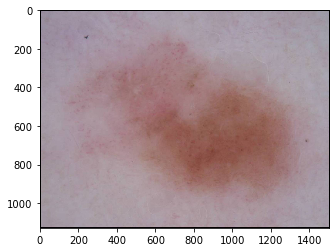

Closest skin disease classe is : nevus

--------------------------------
- Processing : data\extra\melanoma\ISIC_0000029.jpg -


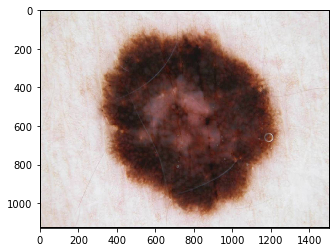

Closest skin disease classe is : nevus

--------------------------------
- Processing : data\extra\nevus\ISIC_0000000.jpg -


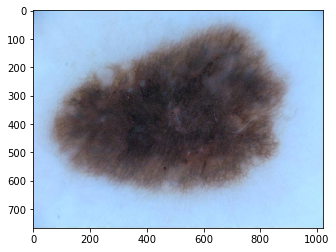

Closest skin disease classe is : nevus

--------------------------------
- Processing : data\extra\nevus\ISIC_0000001.jpg -


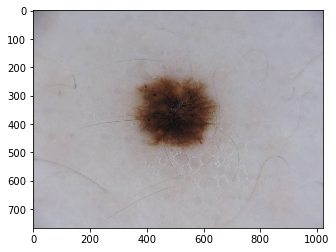

Closest skin disease classe is : nevus

--------------------------------
- Processing : data\extra\nevus\ISIC_0000003.jpg -


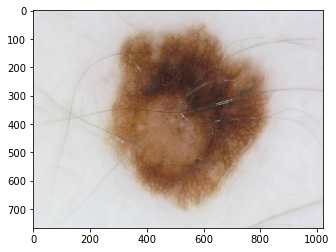

Closest skin disease classe is : nevus

--------------------------------


In [58]:
from glob import glob

# i copied 3x3 copied images, each 3 from test/train/valid set :

extraDataPath = os.path.join(rootDataDir, 'extra/')# on local repo
#extraDataPath = os.path.join(rootDataDir+'/test/', 'melanoma/')# on local repo

# load filenames for human and dog images
some_images_files = np.array(glob(extraDataPath+"/*/*")) #np.array(glob("lfw/*/*"))
#some_images_files = np.array(glob(extraDataPath+"/*"))

print("Will test some of the {} image(s) from folder {}".format(len(some_images_files), extraDataPath))


for file in some_images_files[:9]:
    run_app(file)


In [ ]:
# now prepare exportation into csv file of the predicted classification for the TEST images

In [60]:
from glob import glob

    
#    
# we'll process ALL the test images (600 images, splitted in 3 folders) :
#

def getBiTaskProbas(testFileName):
    pred_class, pred_class_idx, classesProba = predict_class_type(testFileName)
    # pass from [[xxx, yyy, zzz]] to [xxx, yyy, zzz] , then from tensor to numpy array
    classes_probs = classesProba.data.numpy().squeeze() #np.asarray(classes_probas.squeeze())
    #print("- Predict. image: {}, \n ,closest classe: {} , overall probas:{} of type:{}\n".format(testFileName, pred_class, classes_probs, type(classesProba) ))
    return classes_probs[0], classes_probs[2]
    

testDataPath = os.path.join(rootDataDir, 'test/')# on local repo

# load filenames for human and dog images
test_images_files = np.array(glob(testDataPath+"/*/*")) #np.array(glob("lfw/*/*"))

nbImages = len(test_images_files)

print("Will test some of the {} image(s) from folder {}: \n".format(nbImages, testDataPath))

#np.savetxt('np.csv', a, fmt='%.2f', delimiter=',', header=" #1,  #2,  #3,  #4")

# on the 3 predictables classes, we output 2 on 3 proba, as we may retrieve the 3thrd easilt
# so we ouput Task_1 being 'melanoma', and Task_2 being 'seborrheic_keratosis'

outPredArray = np.ndarray(shape=(nbImages, 3), dtype='object')

for fileIdx in range(0, nbImages):
    testFileName = test_images_files[fileIdx]
    tk1_proba, tk2_proba = getBiTaskProbas(testFileName)
    outPredArray[fileIdx,0] = testFileName
    outPredArray[fileIdx,1] = tk1_proba
    outPredArray[fileIdx,2] = tk2_proba

# save file
np.savetxt('sample_predictions_VGG19_VA.csv', outPredArray, fmt='%s',delimiter=',', header="Id,task_1,task_2", comments='' )


Will test some of the 600 image(s) from folder data\test/: 

